In [1]:
%pwd

u'/Users/firas/Box Sync/Home Folder fsm3/Sync/schmid/data.plus.code/_main_scripts'

In [2]:
from scipy.io import loadmat

import pandas as pd, \
       numpy  as np, \
       matplotlib.pyplot as plt, \
       seaborn as sns
        
%matplotlib inline

###Find index for biomass turnover flux in FBA model 

In [3]:
rxns          = pd.read_csv('../_model_definition/transitionIds.txt',sep='\t',header=None,index_col=None)
rxn_ids       = [x.strip() for x in np.ravel(rxns.values)];
biomass_index = np.where([rxn_ids[x]=='ER90000' for x in range(len(rxn_ids))])[0][0]
biomass_index

660

###Load PROM/FBA-predicted fluxes

In [4]:
matlab = loadmat('../_main_scripts/_output/PROM_HaloS_output.mat');
v0_all = matlab['v0_all']
v_all  = matlab['v_all']

/Library/Python/2.7/site-packages/numpy-1.9.2-py2.7-macosx-10.9-intel.egg/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


###Import Gonzalez et al H. salinarum FBA model parameters (including actual growth experiment measurements)

In [13]:
CELLS_PER_OD_ML           = 1.2e+9;
AVOGADROS_NUMBER          = 6.02e23;
CONTAINER_VOLUME_MICROL   = 30000;
MEASUREMENT_VOLUME_MICROL = 0.5;

ATP_ATTO_MOL_PER_HOUR_KLETT_ML = 43699857509;

# Set to 1 if all media components are to be plotted
PLOT_ALL      = 0;

START_TIME    = 36.78;
END_TIME      = 143;#95; 
DELTA_TIME    = 2.02; 
INITIAL_KLETT = 2.0;

# ********** Initialize experimental data values **********
klett_data_in   = pd.read_csv('../_fba_only/Main/_main_output/gonzalez_klett.txt',sep='\t',header=0,index_col=None);
klett_time_data = klett_data_in.loc[:,'klett_time_data'].values;
klett_data      = klett_data_in.loc[:,'klett_data'].values;

klett       = INITIAL_KLETT;
klett1      = INITIAL_KLETT;
deltaKlett  = 0;
deltaKlett1 = 0; 

###Convert predicted flux rates to klett measurements

In [6]:
ctr = -1;
time_series   = [];
klett_series  = [];
klett_series1 = [];
for t in np.arange(start=START_TIME,stop=END_TIME,step=DELTA_TIME):
    ctr+=1;
    time_series.append(t);
    
    #Cells produced per measurement volume unit
    cellsPerVolumeUnit  = v0_all[biomass_index,ctr]*(float(1e-9)/float(1e-18));
    cellsPerVolumeUnit1 =  v_all[biomass_index,ctr]*(float(1e-9)/float(1e-18));

    #Compute cells per ml
    cellsPerML  =  float(cellsPerVolumeUnit*(1e-3))/float(MEASUREMENT_VOLUME_MICROL*1e-6)
    cellsPerML1 = float(cellsPerVolumeUnit1*(1e-3))/float(MEASUREMENT_VOLUME_MICROL*1e-6)

    #Compute change in klett
    deltaKlett  = (float(cellsPerML)/float(CELLS_PER_OD_ML))*100;
    deltaKlett1 = (float(cellsPerML1)/float(CELLS_PER_OD_ML))*100;

    klett+=deltaKlett;
    klett1+=deltaKlett1;
    
    klett_series.append(klett);
    klett_series1.append(klett1);

###Plot growth curves for wild-type $\Delta{ura3}$ and knock-out $\Delta{trmB}$ strains

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/backends/backend_pdf.py:2036: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


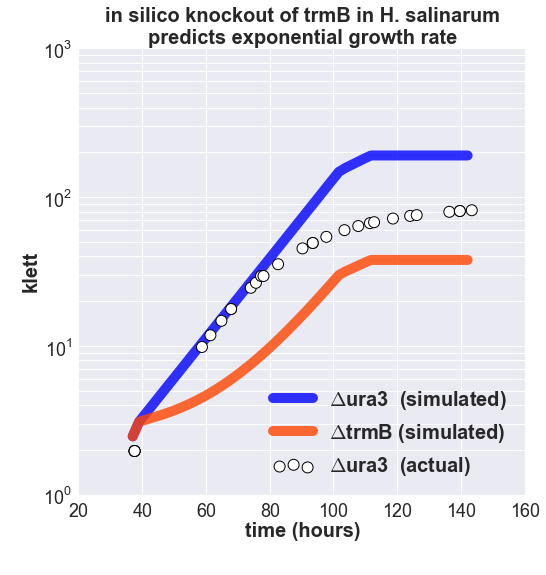

In [7]:
sns.set()

fig = plt.figure(figsize=[8,8], facecolor='w', edgecolor='k');

plt.plot(time_series,klett_series,color='blue',alpha=0.8,lw=10,zorder=1)
plt.plot(time_series,klett_series1,color='orangered',alpha=0.8,lw=10,zorder=2)
plt.scatter(klett_time_data,klett_data,s=120,edgecolor='black',facecolor='white',lw=1,zorder=3)

plt.xlabel('time (hours)',fontsize=20,fontweight='bold')
plt.ylabel('klett',fontsize=20,fontweight='bold')
#plt.title(r'$\it{in}$ $\it{silico}$ knockout of $\it{trmB}$ in $\it{H.}$ $\it{salinarum}$'+'\n'+'predicts exponential growth rate',fontsize=20,fontweight='bold')
plt.title('in silico knockout of trmB in H. salinarum'+'\n'+'predicts exponential growth rate',fontsize=20,fontweight='bold')
plt.legend([r'$\Delta$ura3  (simulated)',r'$\Delta$trmB (simulated)',r'$\Delta$ura3  (actual)'],loc=4,prop={'size':20,'weight':'bold'})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')

plt.savefig('./growth.curves.pdf', format='pdf', dpi=1000)
plt.show()
plt.show()

###Export results for growth curve fitting

In [12]:
actual    = pd.DataFrame([klett_time_data,klett_data],index=['time','actual']).transpose().set_index(['time'])
simulated = pd.DataFrame([time_series,klett_series,klett_series1],index=['time','ura3','trmb']).transpose().set_index(['time'])

actual.to_csv('./_output/growth_measurements_actual.csv',sep=',',header=True,index_col=0);
simulated.to_csv('./_output/growth_measurements_simulated.csv',sep=',',header=True,index_col=0);

###growth_curve_fit_midani.m to fit growth data to logistic and gompertz curves